# Portfolio vs S&P 500: Market Views and Stress-Tests
Replicating the Chapter 7.2 framework for a 12-asset portfolio against S&P 500.

In [2]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Load data and compute portfolio returns

In [27]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
benchmark = '^GSPC'
all_assets = selected_assets + [benchmark]

existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

pnl = np.diff(np.log(data_clean.values), axis=0)
pnl = pd.DataFrame(pnl, index=data_clean.index[1:], columns=data_clean.columns)

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

Returns: 2470 days × 13 assets
Date range: 2016-01-05 → 2025-11-11


In [28]:
# Portfolio weights - 20-fold exposure stacking from optimization
exposures = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

# Extract investable returns and benchmark
R_investable = pnl[selected_assets].values
R_benchmark = pnl[benchmark].values

# Compute portfolio return series
portfolio_return = R_investable @ exposures

# Specify prior parameters and simulate

In [49]:
# Annualize for simulation (H = 252 trading days)
H = 252

# Stack portfolio and benchmark for 2-asset analysis
returns_2d = np.column_stack([portfolio_return, R_benchmark])
means = np.mean(returns_2d, axis=0) * H
vols = np.std(returns_2d, axis=0) * np.sqrt(H)
corr = np.corrcoef(returns_2d.T)
covariances = np.diag(vols) @ corr @ np.diag(vols)

print(f"Portfolio: mean={means[0]*100:.1f}%, vol={vols[0]*100:.1f}%")
print(f"S&P 500:   mean={means[1]*100:.1f}%, vol={vols[1]*100:.1f}%")
print(f"Correlation: {corr[0,1]:.3f}")

Portfolio: mean=21.2%, vol=17.0%
S&P 500:   mean=12.5%, vol=18.3%
Correlation: 0.887


In [50]:
# Simulate log-normal returns
S = 10000
np.random.seed(1337)
log_return = np.random.multivariate_normal(means, covariances, S)
discrete_return = pd.DataFrame(
    np.exp(log_return - np.diag(np.cov(log_return.T)) / 2) - 1,
    columns=['Portfolio', 'S&P 500'])

In [51]:
# Validate simulation
ft.simulation_moments(100 * discrete_return)

,Mean,Volatility,Skewness,Kurtosis
Portfolio,23.601993,21.077616,0.526170,3.424037
S&P 500,13.343887,20.599033,0.543788,3.411715


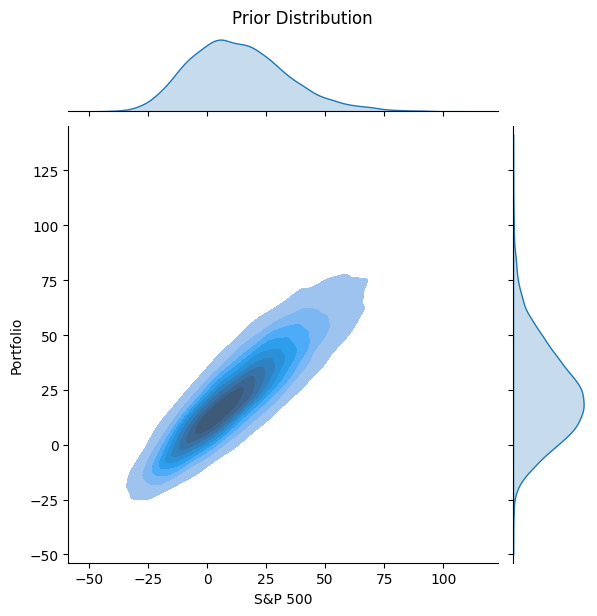

In [52]:
# Joint plot - Prior distribution (Figure 7.2.1 equivalent)
sns.jointplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', kind='kde', fill=True)
plt.suptitle('Prior Distribution', y=1.02)
plt.show()

# View on S&P 500 (mean and variance)

In [53]:
# Condition on S&P 500 mean = 7.5% and vol = 27.5%
A = np.ones((1, S))
A = np.vstack((A, discrete_return.values[:, 1]))  # S&P 500 mean
A = np.vstack((A, (discrete_return.values[:, 1] - 0.075)**2))  # S&P 500 variance
b = np.array([[1., 0.075, 0.275**2]]).T

In [54]:
p = np.ones((S, 1)) / S
q_view = ft.entropy_pooling(p, A, b)
relative_entropy_view = q_view.T @ (np.log(q_view) - np.log(p))
effective_number_scenarios_view = np.exp(-relative_entropy_view)
print(f'Effective number of scenarios view = {np.round(effective_number_scenarios_view[0, 0] * 100, 2)}%.')
print(f'Relative entropy view = {np.round(relative_entropy_view[0, 0] * 100, 2)}%.')

Effective number of scenarios view = 82.08%.
Relative entropy view = 19.75%.


In [55]:
# Validate view implementation
np.round(ft.simulation_moments(100 * discrete_return, p=q_view), 3)

,Mean,Volatility,Skewness,Kurtosis
Portfolio,17.958,26.1,0.923,3.926
S&P 500,7.500,27.5,1.134,4.488


# C0 Stress-Test: Portfolio at CVaR

In [56]:
# Compute portfolio CVaR
pf_exposures = np.array([[1.], [0.]])  # 100% portfolio, 0% benchmark
portfolio_cvar = ft.portfolio_cvar(pf_exposures, discrete_return, alpha=0.9, demean=False)
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

Portfolio 90%-CVaR = 8.996%


In [57]:
# C0: Condition on portfolio return = CVaR
A0 = np.ones((1, S))
A0 = np.vstack((A0, discrete_return.values[:, 0]))  # Portfolio return
b0 = np.array([[1., -portfolio_cvar]]).T
q0 = ft.entropy_pooling(p, A0, b0)

In [58]:
relative_entropy_0 = q0.T @ (np.log(q0) - np.log(p))
effective_number_scenarios_0 = np.exp(-relative_entropy_0)
print(f'Effective number of scenarios intermediate stress-test = {np.round(effective_number_scenarios_0[0, 0] * 100, 2)}%.')
print(f'Relative entropy intermediate stress-test = {np.round(relative_entropy_0[0, 0] * 100, 2)}%.')

Effective number of scenarios intermediate stress-test = 19.15%.
Relative entropy intermediate stress-test = 165.28%.


In [59]:
# Validate that portfolio expected return equals CVaR
stats0 = ft.simulation_moments(discrete_return, q0)
display(np.round(stats0, 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.090,0.134,0.255,3.429
S&P 500,-0.152,0.139,0.338,3.411


Portfolio 90%-CVaR = 8.996%


# C4 Stress-Test: Correlation spike

In [60]:
# C4: Add correlation constraint (spike to 0.90)
stress_correlation = 0.90

A4 = np.ones((1, S))
# Means
A4 = np.vstack((A4, discrete_return.values[:, 0:2].T))
# Volatilities
A4 = np.vstack((A4, (discrete_return.values[:, 0:2].T - stats0['Mean'].values[0:2][:, np.newaxis])**2))
# Correlation
A4 = np.vstack((A4, (discrete_return.values[:, 0] - stats0['Mean'].values[0]) * 
                    (discrete_return.values[:, 1] - stats0['Mean'].values[1]) /
                    (stats0['Volatility'].values[0] * stats0['Volatility'].values[1])))

b4 = np.array([[1., *stats0['Mean'].iloc[0:2], *stats0['Volatility'].iloc[0:2]**2, stress_correlation]]).T

In [61]:
q_stress = ft.entropy_pooling(p, A4, b4)
relative_entropy_stress = q_stress.T @ (np.log(q_stress) - np.log(p))
effective_number_scenarios_stress = np.exp(-relative_entropy_stress)
print(f'Effective number of scenarios stress-test = {np.round(effective_number_scenarios_stress[0, 0] * 100, 2)}%.')
print(f'Relative entropy stress-test = {np.round(relative_entropy_stress[0, 0] * 100, 2)}%.')

Effective number of scenarios stress-test = 18.68%.
Relative entropy stress-test = 167.75%.


In [62]:
# Validate final posterior values
stats_q = ft.simulation_moments(discrete_return, q_stress)
display(np.round(stats_q, 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.090,0.134,0.271,3.431
S&P 500,-0.152,0.139,0.338,3.438


Portfolio 90%-CVaR = 8.996%


In [63]:
# Validate final posterior correlations
ft.correlation_matrix(discrete_return, q_stress)

,0,1
"(0, Portfolio)",1.0,0.9
"(1, S&P 500)",0.9,1.0


# Comparison plots

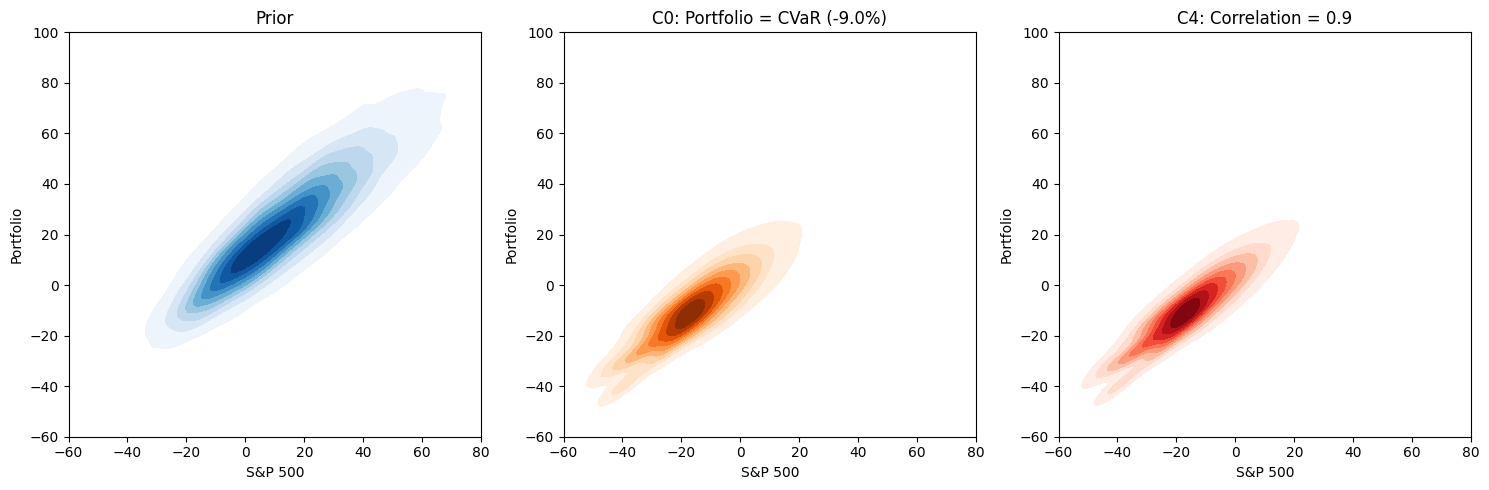

In [64]:
# Prior distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Prior
ax1 = axes[0]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            fill=True, ax=ax1, cmap='Blues')
ax1.set_title('Prior')
ax1.set_xlim(-60, 80)
ax1.set_ylim(-60, 100)

# C0: Portfolio at CVaR
ax2 = axes[1]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q0[:, 0], fill=True, ax=ax2, cmap='Oranges')
ax2.set_title(f'C0: Portfolio = CVaR ({-portfolio_cvar*100:.1f}%)')
ax2.set_xlim(-60, 80)
ax2.set_ylim(-60, 100)

# C4: Correlation stress
ax3 = axes[2]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q_stress[:, 0], fill=True, ax=ax3, cmap='Reds')
ax3.set_title(f'C4: Correlation = {stress_correlation}')
ax3.set_xlim(-60, 80)
ax3.set_ylim(-60, 100)

plt.tight_layout()
plt.show()

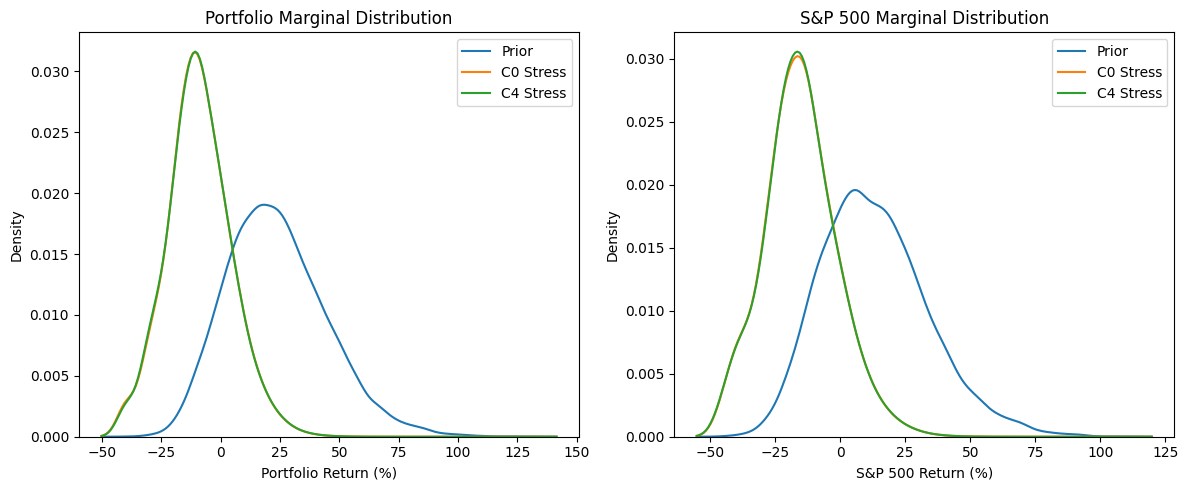

In [65]:
# Marginal distributions comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Portfolio marginal
ax1 = axes[0]
sns.kdeplot(x=100 * discrete_return['Portfolio'], ax=ax1, label='Prior')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q0[:, 0], ax=ax1, label='C0 Stress')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q_stress[:, 0], ax=ax1, label='C4 Stress')
ax1.set_xlabel('Portfolio Return (%)')
ax1.set_title('Portfolio Marginal Distribution')
ax1.legend()

# S&P 500 marginal
ax2 = axes[1]
sns.kdeplot(x=100 * discrete_return['S&P 500'], ax=ax2, label='Prior')
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q0[:, 0], ax=ax2, label='C0 Stress')
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q_stress[:, 0], ax=ax2, label='C4 Stress')
ax2.set_xlabel('S&P 500 Return (%)')
ax2.set_title('S&P 500 Marginal Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

In [66]:
# Summary table
summary = pd.DataFrame({
    'Prior': [
        ft.simulation_moments(discrete_return, p)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, p)['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, p).iloc[0, 1],
        100.0
    ],
    'C0 Stress': [
        stats0['Mean']['Portfolio'] * 100,
        stats0['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, q0).iloc[0, 1],
        effective_number_scenarios_0[0, 0] * 100
    ],
    'C4 Stress': [
        stats_q['Mean']['Portfolio'] * 100,
        stats_q['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, q_stress).iloc[0, 1],
        effective_number_scenarios_stress[0, 0] * 100
    ]
}, index=['Portfolio Mean (%)', 'Portfolio Vol (%)', 'Correlation', 'Effective Scenarios (%)'])

np.round(summary, 3)

,Prior,C0 Stress,C4 Stress
Portfolio Mean (%),23.602,-8.996,-8.996
Portfolio Vol (%),21.078,13.425,13.425
Correlation,0.885,0.860,0.900
Effective Scenarios (%),100.000,19.151,18.685


# Alternative: S&P 500 crash stress test

In [67]:
# Stress test: S&P 500 at its CVaR
sp500_cvar = ft.portfolio_cvar(np.array([[0.], [1.]]), discrete_return, alpha=0.9, demean=False)
print(f'S&P 500 90%-CVaR = {np.round(100 * sp500_cvar, 3)}%')

A_sp = np.ones((1, S))
A_sp = np.vstack((A_sp, discrete_return.values[:, 1]))  # S&P 500
b_sp = np.array([[1., -sp500_cvar]]).T

q_sp_stress = ft.entropy_pooling(p, A_sp, b_sp)

print(f"\nWhen S&P 500 is at its CVaR ({-sp500_cvar*100:.1f}%):")
stats_sp = ft.simulation_moments(discrete_return, q_sp_stress)
display(np.round(stats_sp, 3))
print(f"\nCorrelation matrix:")
display(ft.correlation_matrix(discrete_return, q_sp_stress))

S&P 500 90%-CVaR = 18.226%

When S&P 500 is at its CVaR (-18.2%):


,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.055,0.143,0.339,3.434
S&P 500,-0.182,0.130,0.319,3.277



Correlation matrix:


,0,1
"(0, Portfolio)",1.000000,0.848578
"(1, S&P 500)",0.848578,1.000000


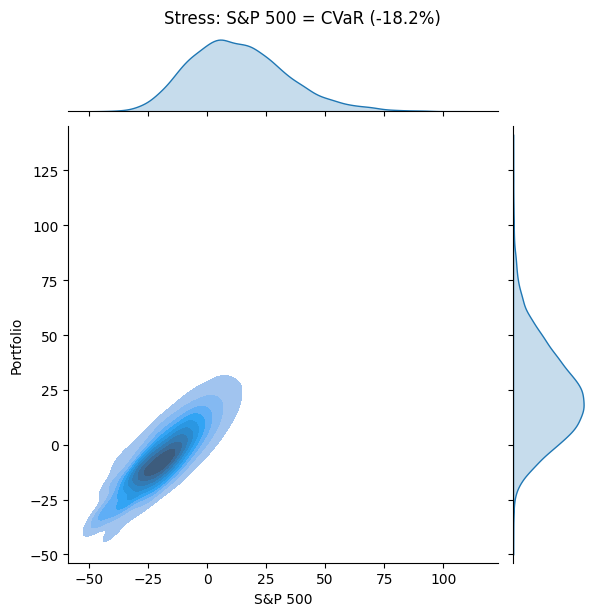

In [68]:
# Joint plot: S&P 500 crash scenario
sns.jointplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
              weights=q_sp_stress[:, 0], kind='kde', fill=True)
plt.suptitle(f'Stress: S&P 500 = CVaR ({-sp500_cvar*100:.1f}%)', y=1.02)
plt.show()